In [3]:
from langgraph.graph import StateGraph,START,END
from langchain_huggingface import ChatHuggingFace,HuggingFaceEndpoint
from typing import TypedDict,Literal
from dotenv import load_dotenv
from pydantic import BaseModel,Field
from langchain.output_parsers import PydanticOutputParser

In [5]:
load_dotenv()

True

In [6]:
llm = HuggingFaceEndpoint(
    model='Qwen/Qwen3-Next-80B-A3B-Instruct',
    task= 'text-generation'
)
model = ChatHuggingFace(llm=llm)

In [7]:
class SentimentSchema(BaseModel):
    sentiment: Literal['positive','negative'] = Field(description='sentiment of the review')

In [8]:
parser_SentimentSchema = PydanticOutputParser(pydantic_object=SentimentSchema)

In [9]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [10]:
parser_DiagnosisSchema = PydanticOutputParser(pydantic_object=DiagnosisSchema)

In [11]:
#review = '"I was really excited to upgrade to the new MacBook, but it has been a disappointing experience. The battery life is far shorter than advertised, barely lasting a full workday. Performance also lags when running multiple apps, which is frustrating given the high price. Additionally, the keyboard feels uncomfortable for long typing sessions, and the limited port selection makes connecting peripherals a hassle. Overall, I expected much more for such an expensive device and feel let down by this purchase.'

In [12]:
# prompt = f"""
# Evaluate the sentiment of the following review and provide a detailed explanation and score.

# Text:
# {review}

# Return output strictly in JSON format following this schema:
# {parser_SentimentSchema.get_format_instructions()}

# Requirements:
# - 'sentiment' must be either "positive" or "negative".

# """

In [13]:
# raw_output = model.invoke(prompt)

In [14]:
# review_Analysis = parser_SentimentSchema.parse(raw_output.content)
# print(review_Analysis.sentiment)

In [15]:
class ReviewState(TypedDict):
    review: str
    sentiment: Literal['positive','negative']
    diagnosis: dict
    response: str

In [16]:
def find_sentiment(state: ReviewState):
    prompt = f"""
for the forllowing review find out the  sentiment and  give its nature  positive or negative\n{state['review']}

Return output strictly in JSON format following this schema:
{parser_SentimentSchema.get_format_instructions()}

"""
    raw_output = model.invoke(prompt)   
    result = parser_SentimentSchema.parse(raw_output.content)

    return {'sentiment':result.sentiment}


In [17]:
def positive_response(state: ReviewState):

    prompt = f"""Write a warm thank-you message in response to this review:
    \n\n\"{state['review']}\"\n
Also, kindly ask the user to leave feedback on our website.
"""
    
    response = model.invoke(prompt).content

    return {'response': response}

In [18]:
def run_diagnosis(state: ReviewState):
    prompt = f"""Diagnose this negative review:

{state['review']}

Return issue_type, tone, and urgency.
Return output strictly in JSON format following this schema: {parser_DiagnosisSchema.get_format_instructions()}
"""
    raw_output = model.invoke(prompt) 
    result = parser_DiagnosisSchema.parse(raw_output.content)

    state['diagnosis'] = result.model_dump()
    return state

In [19]:
def negative_response(state: ReviewState):
    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = model.invoke(prompt).content  
    state['response'] = response
    return state

In [20]:
def check_sentiment(state: ReviewState) -> Literal['positive_response','run_diagnosis']:
    if state['sentiment']=='positive':
        return 'positive_response'
    
    else:
        return 'run_diagnosis'


In [21]:
graph = StateGraph(ReviewState)

graph.add_node('find_sentiment', find_sentiment)
graph.add_node('positive_response', positive_response)
graph.add_node('run_diagnosis', run_diagnosis)
graph.add_node('negative_response', negative_response)

graph.add_edge(START, 'find_sentiment')

graph.add_conditional_edges('find_sentiment', check_sentiment)

graph.add_edge('positive_response', END)

graph.add_edge('run_diagnosis', 'negative_response')
graph.add_edge('negative_response', END)

workflow = graph.compile()

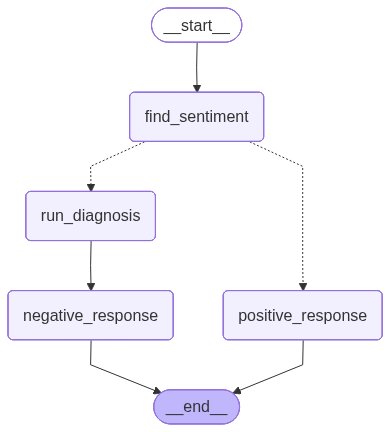

In [22]:
workflow

In [23]:
intial_state={
    'review': "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}
final = workflow.invoke(intial_state)

In [24]:
def pretty_print_review(state):
    print("\n" + "="*60)
    print("📝 Customer Review:")
    print("-"*60)
    print(state['review'])
    
    print("\n💬 Sentiment Analysis:")
    print("-"*60)
    print(f"Sentiment: {state['sentiment'].capitalize()}")
    
    print("\n🔍 Diagnosis:")
    print("-"*60)
    diagnosis = state.get('diagnosis', {})
    print(f"Issue Type : {diagnosis.get('issue_type', 'N/A')}")
    print(f"Tone       : {diagnosis.get('tone', 'N/A')}")
    print(f"Urgency    : {diagnosis.get('urgency', 'N/A')}")
    
    print("\n📧 Response:")
    print("-"*60)
    print(state.get('response', 'No response available.'))
    print("="*60 + "\n")



In [25]:
pretty_print_review(final)


📝 Customer Review:
------------------------------------------------------------
I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality.

💬 Sentiment Analysis:
------------------------------------------------------------
Sentiment: Negative

🔍 Diagnosis:
------------------------------------------------------------
Issue Type : Bug
Tone       : angry
Urgency    : high

📧 Response:
------------------------------------------------------------
I’m so sorry you’re experiencing this issue—and I completely understand why you’re frustrated. This kind of bug is not only disruptive, it’s downright unacceptable, and I truly apologize for the stress and time this has cost you.

You’ve got my full attention, and I’m treating this as urgent—because you should never have to wait when something’s broken. I’ve already escalated th